In [1]:
%pip install -Uqq fastai
%pip install duckduckgo_search

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

In [3]:
def search_images(term, max_images=50):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results = max_images)).itemgot('image')

Searching for 'comedy movie posters'


c:\Users\david\anaconda3\Lib\site-packages\duckduckgo_search\compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


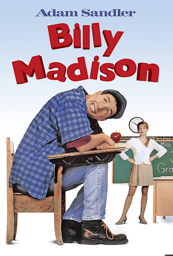

In [4]:
from fastdownload import download_url
urls = search_images('comedy movie posters', max_images=1)
dest = 'comedyMovie.jpg'
download_url(urls[0], dest, show_progress=True)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'action movie posters'


c:\Users\david\anaconda3\Lib\site-packages\duckduckgo_search\compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


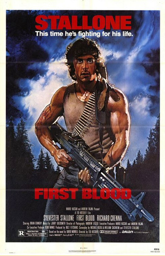

In [5]:
download_url(search_images('action movie posters', max_images=1)[0], 'actionMovie.jpg', show_progress=True)
Image.open('actionMovie.jpg').to_thumb(256,256)

Searching for 'romance movie posters'


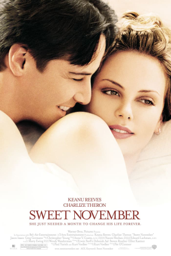

In [6]:
download_url(search_images('romance movie posters', max_images=1)[0], 'romanceMovie.jpg', show_progress=True)
Image.open('romanceMovie.jpg').to_thumb(256,256)

In [7]:
searches = 'romance movie posters', 'action movie posters', 'comedy movie posters'
path = Path('romance action or comedy')
from time import sleep

In [8]:
for term in searches:
    dest = (path/term)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{term}'))
    sleep(10)
    resize_images(path/term, max_size=400, dest=path/term)

Searching for 'romance movie posters'
Searching for 'action movie posters'
Searching for 'comedy movie posters'


In [9]:
failed = verify_images(get_image_files(path))
failed
failed.map(Path.unlink)
len(failed)

3

c:\Users\david\anaconda3\Lib\site-packages\fastai\torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


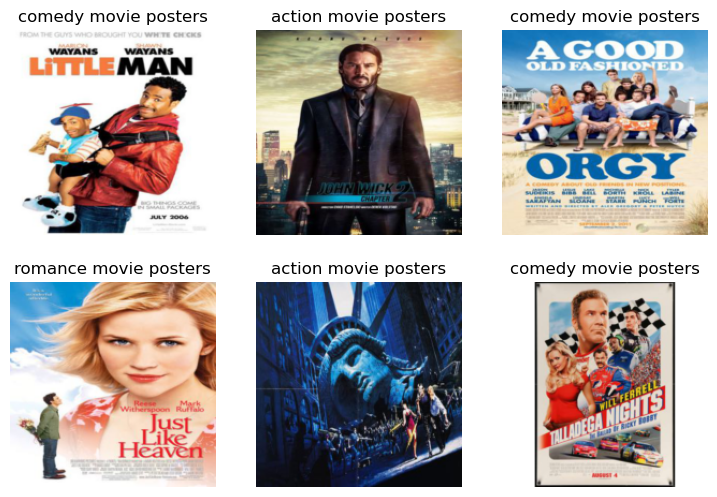

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(11)

epoch,train_loss,valid_loss,error_rate,time
0,1.651404,1.173654,0.392857,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.743618,0.588621,0.196429,00:19
1,0.486973,0.450731,0.160714,00:20
2,0.355165,0.401124,0.125000,00:22
3,0.267544,0.661519,0.142857,00:21
4,0.213991,0.502834,0.125000,00:21
5,0.175987,0.419606,0.089286,00:20
6,0.140227,0.330371,0.089286,00:21
7,0.120407,0.332596,0.089286,00:24
8,0.102656,0.352329,0.089286,00:23
9,0.094071,0.364475,0.089286,00:28


In [12]:
is_romance,_,probs = learn.predict(PILImage.create('romanceMovie.jpg'))
print(f"This is a: {is_romance}.")
print(f"Probability it's a romance movie: {probs[2]:.4f}")

This is a: romance movie posters.
Probability it's a romance movie: 0.9998


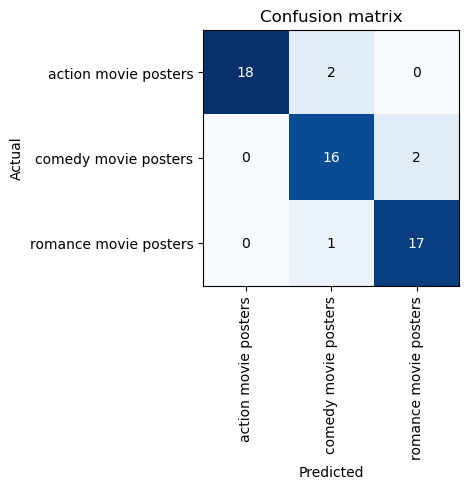

In [13]:

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

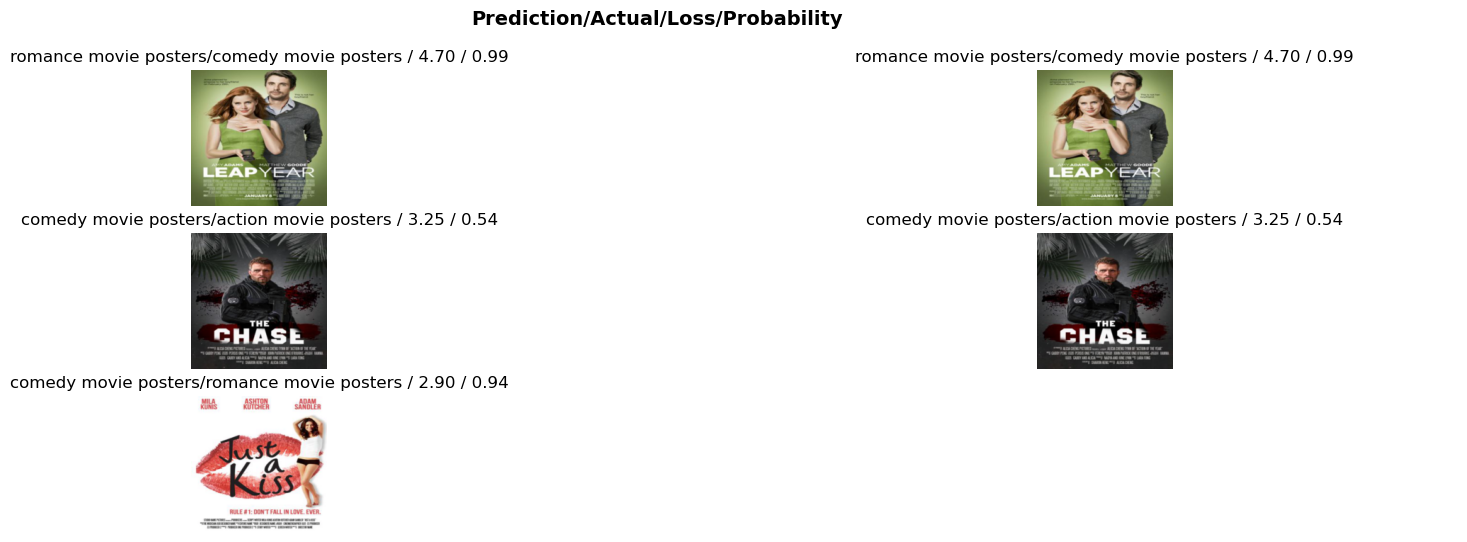

In [14]:
interp.plot_top_losses(5, nrows=3, figsize=(20,6))


In [15]:

from fastai.vision.widgets import ImageClassifierCleaner
cleaner = ImageClassifierCleaner(learn)
cleaner

In [30]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)